# Word2Vec Skip-Gram — Implementação Didática em PyTorch

O modelo **Skip-Gram** aprende a prever palavras de contexto dadas palavras centrais em uma janela.

Proposto por Mikolov et al. (2013), é um dos métodos mais influentes para gerar **word embeddings distribuídos**.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np

## 1. Preparação do corpus

Usaremos um corpus mínimo apenas para ilustração.

In [11]:
corpus = "o rei lidera o reino e a rainha governa o país"
tokens = corpus.lower().split()
vocab = sorted(set(tokens))
vocab_size = len(vocab)

word_to_ix = {w: i for i, w in enumerate(vocab)}
ix_to_word = {i: w for w, i in word_to_ix.items()}

print("Vocabulário:", vocab)

Vocabulário: ['a', 'e', 'governa', 'lidera', 'o', 'país', 'rainha', 'rei', 'reino']


## 2. Gerando pares Skip-Gram

Para cada palavra central, criamos pares (palavra_central, palavra_contexto) dentro de uma janela de tamanho fixo.

In [12]:
def generate_skipgram_pairs(tokens, window_size=2):
    pairs = []
    for i, word in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                pairs.append((word, tokens[j]))
    return pairs

pairs = generate_skipgram_pairs(tokens, window_size=2)
print("Exemplos de pares:", pairs[:10])
print("Total de pares:", len(pairs))

Exemplos de pares: [('o', 'rei'), ('o', 'lidera'), ('rei', 'o'), ('rei', 'lidera'), ('rei', 'o'), ('lidera', 'o'), ('lidera', 'rei'), ('lidera', 'o'), ('lidera', 'reino'), ('o', 'rei')]
Total de pares: 38


## 3. Dataset PyTorch

Cada par (input, target) é transformado em índice.

In [13]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs, word_to_ix):
        self.pairs = pairs
        self.word_to_ix = word_to_ix

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        w, c = self.pairs[idx]
        return torch.tensor(self.word_to_ix[w]), torch.tensor(self.word_to_ix[c])

dataset = SkipGramDataset(pairs, word_to_ix)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

## 4. Modelo Skip-Gram

Duas camadas de embeddings:
- `emb_in`: representa a palavra central;
- `emb_out`: representa palavras de contexto.

In [14]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_in = nn.Embedding(vocab_size, emb_dim)
        self.emb_out = nn.Embedding(vocab_size, emb_dim)

    def forward(self, center_words, context_words):
        v_c = self.emb_in(center_words)
        v_o = self.emb_out(context_words)
        score = torch.sum(v_c * v_o, dim=1)
        log_probs = F.logsigmoid(score)
        return -log_probs.mean()

model = SkipGramModel(vocab_size=vocab_size, emb_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 5. Treinamento

In [15]:
for epoch in range(300):
    total_loss = 0
    for center, context in loader:
        optimizer.zero_grad()
        loss = model(center, context)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 60 == 0:
        print(f"Época {epoch+1} | Loss médio: {total_loss/len(loader):.4f}")

Época 60 | Loss médio: 0.0091
Época 120 | Loss médio: 0.0024
Época 180 | Loss médio: 0.0010
Época 240 | Loss médio: 0.0005
Época 300 | Loss médio: 0.0003


## 6. Visualização dos embeddings aprendidos

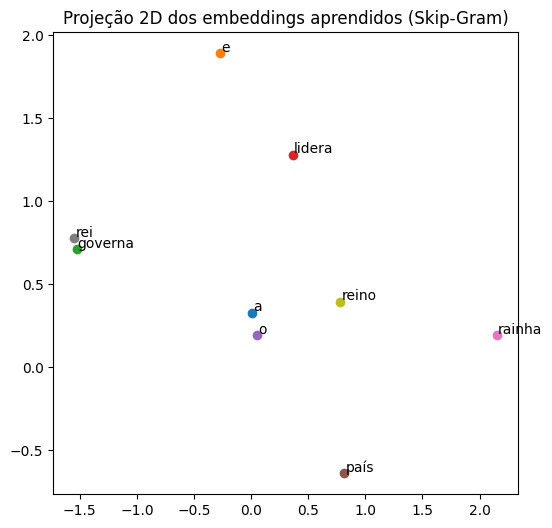

In [16]:
embeddings = model.emb_in.weight.detach().to(torch.float32)

plt.figure(figsize=(6,6))
for i, word in enumerate(vocab):
    x, y = embeddings[i, 0].item(), embeddings[i, 1].item()
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=10)
plt.title("Projeção 2D dos embeddings aprendidos (Skip-Gram)")
plt.show()

## 7. Palavras semanticamente próximas

Usamos similaridade de cosseno para encontrar palavras mais próximas no espaço vetorial.

In [18]:
def closest(word, topn=3):
    if word not in word_to_ix:
        return []
    
    idx = word_to_ix[word]
    wv = embeddings[idx]                      # vetor da palavra alvo
    # produto interno entre o vetor alvo e todos os vetores
    sims = torch.matmul(embeddings, wv) / (
        torch.norm(embeddings, dim=1) * torch.norm(wv)
    )
    
    # índices ordenados por similaridade decrescente
    best = torch.argsort(sims, descending=True)[1:topn+1]
    return [(ix_to_word[int(i)], float(sims[i])) for i in best]

for w in ["rei", "rainha", "reino"]:
    print(f"Mais próximos de '{w}':", closest(w))

Mais próximos de 'rei': [('reino', 0.565010666847229), ('governa', 0.3997943103313446), ('lidera', 0.25115522742271423)]
Mais próximos de 'rainha': [('reino', 0.6859980225563049), ('e', 0.3562089204788208), ('lidera', 0.3447076976299286)]
Mais próximos de 'reino': [('rainha', 0.6859980225563049), ('rei', 0.565010666847229), ('o', 0.2798245847225189)]
